In [9]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

from modules.Utils.utils import loadFromDB
import numpy as np
from hmmlearn import hmm
import pandas as pd

In [73]:
SYMBOL= 'ETH'
df =loadFromDB(SYMBOL,'1h').iloc[7000:]
df['Return'] = df['Close'].pct_change()

df.dropna(inplace=True)
print(df.shape)
df.head()

(14007, 7)


,Open,High,Low,Close,Volume,Timestamp,Return
Date,,,,,,,
2021-03-19 17:00:00,1823.00,1825.65,1816.59,1822.00,17186.90550,1616173200,-0.000554
2021-03-19 18:00:00,1822.00,1825.99,1812.02,1823.94,15708.54762,1616176800,0.001065
2021-03-19 19:00:00,1823.94,1828.00,1822.00,1826.64,14385.20070,1616180400,0.001480
2021-03-19 20:00:00,1826.54,1840.61,1812.26,1817.26,31201.18261,1616184000,-0.005135
2021-03-19 21:00:00,1817.26,1831.24,1814.28,1825.80,11311.82668,1616187600,0.004699


/home/baptiste/windowsdisk/_sharedFS/Python/python-trading-bot/venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


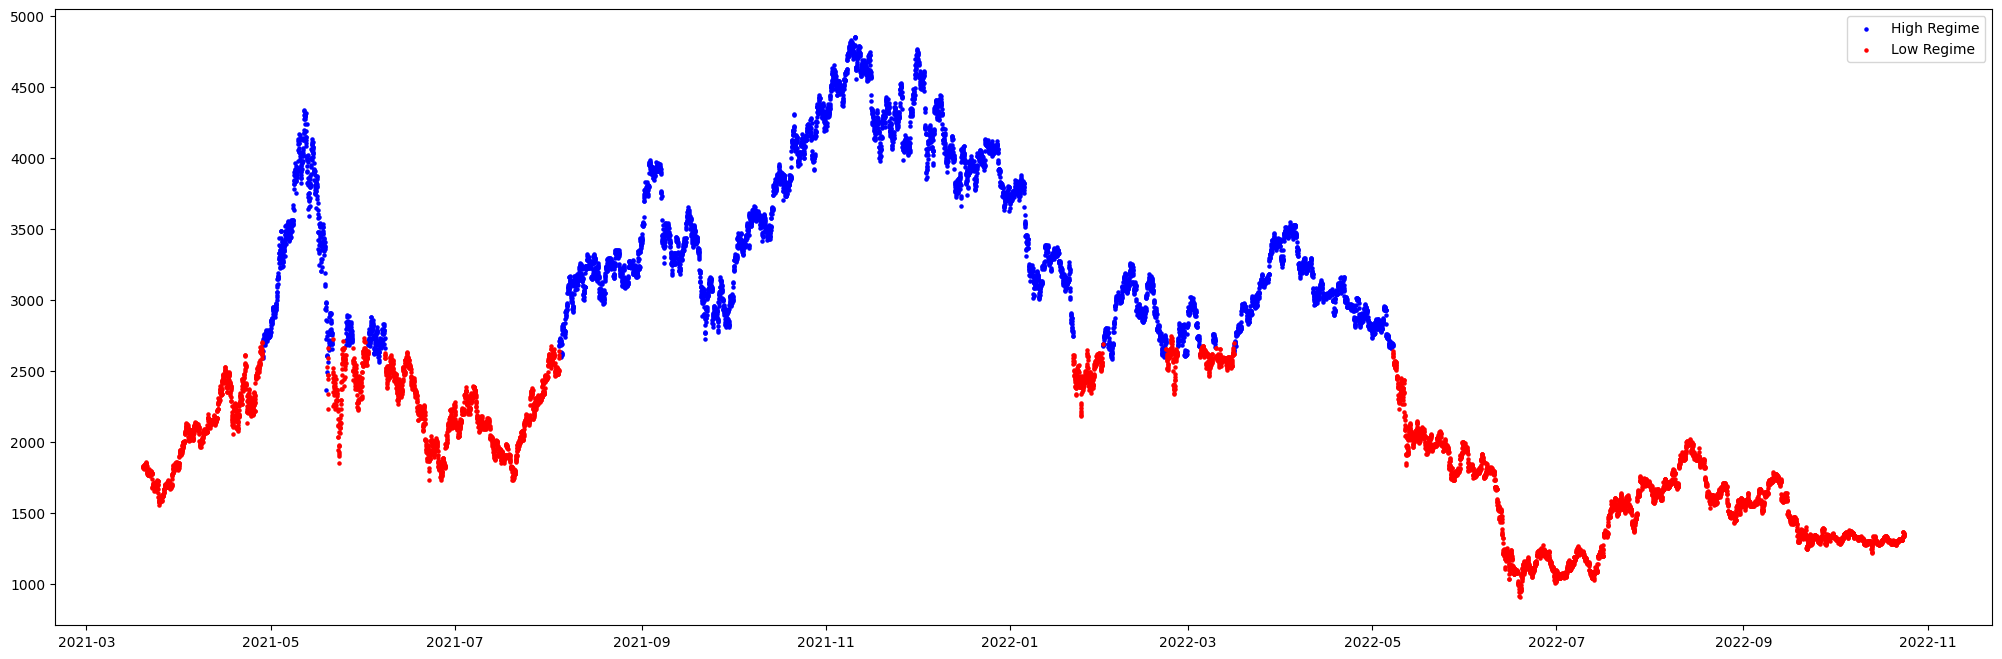

In [74]:
model = MarkovRegression(df.Close, k_regimes=2, trend='c', switching_variance=False,order=2)
res_kns = model.fit()
#res_kns.summary()

df['Low_regime_proba'] = tuple(res_kns.smoothed_marginal_probabilities[0])
df['High_regime_proba'] = tuple(res_kns.smoothed_marginal_probabilities[1])


df['Regime'] = df.apply(lambda x: 1 if x['Low_regime_proba'] < x['High_regime_proba'] else 0, axis=1)

high_regime_df = df[df['Regime'] == 1]
low_regime_df = df[df['Regime'] == 0]


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))
plt.scatter(high_regime_df.index,high_regime_df['Close'], color='blue',s=5,label='High Regime')
plt.scatter(low_regime_df.index,low_regime_df['Close'], color='red',s=5,label='Low Regime')
plt.legend()

# HMM learn

In [12]:
SYMBOL= 'ETH'
df =loadFromDB(SYMBOL,'1h').iloc[7000:]
df['Log'] = np.log(df['Close'])
df['Return'] = df['Close'].pct_change()
df['Range'] = (df['High'] / df['Low']) - 1

df.dropna(inplace=True)
print(df.shape)
df.head()

(14007, 9)


,Open,High,Low,Close,Volume,Timestamp,Log,Return,Range
Date,,,,,,,,,
2021-03-19 17:00:00,1823.00,1825.65,1816.59,1822.00,17186.90550,1616173200,7.507690,-0.000554,0.004987
2021-03-19 18:00:00,1822.00,1825.99,1812.02,1823.94,15708.54762,1616176800,7.508754,0.001065,0.007710
2021-03-19 19:00:00,1823.94,1828.00,1822.00,1826.64,14385.20070,1616180400,7.510233,0.001480,0.003293
2021-03-19 20:00:00,1826.54,1840.61,1812.26,1817.26,31201.18261,1616184000,7.505085,-0.005135,0.015643
2021-03-19 21:00:00,1817.26,1831.24,1814.28,1825.80,11311.82668,1616187600,7.509774,0.004699,0.009348


<AxesSubplot: >

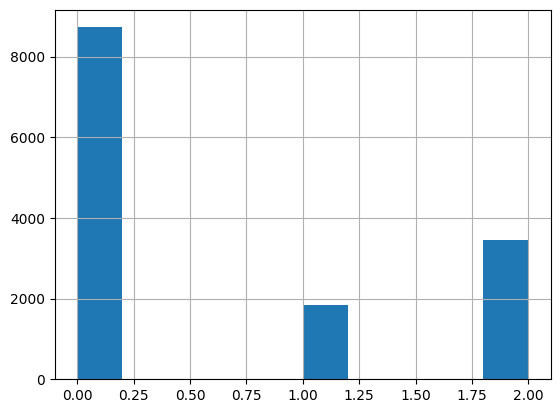

In [13]:
data = df[['Return', 'Range']]
model = hmm.GaussianHMM(n_components=3, covariance_type='full')
model.fit(data)
model.score(data)

states = model.predict(data)

pd.Series(states).hist()

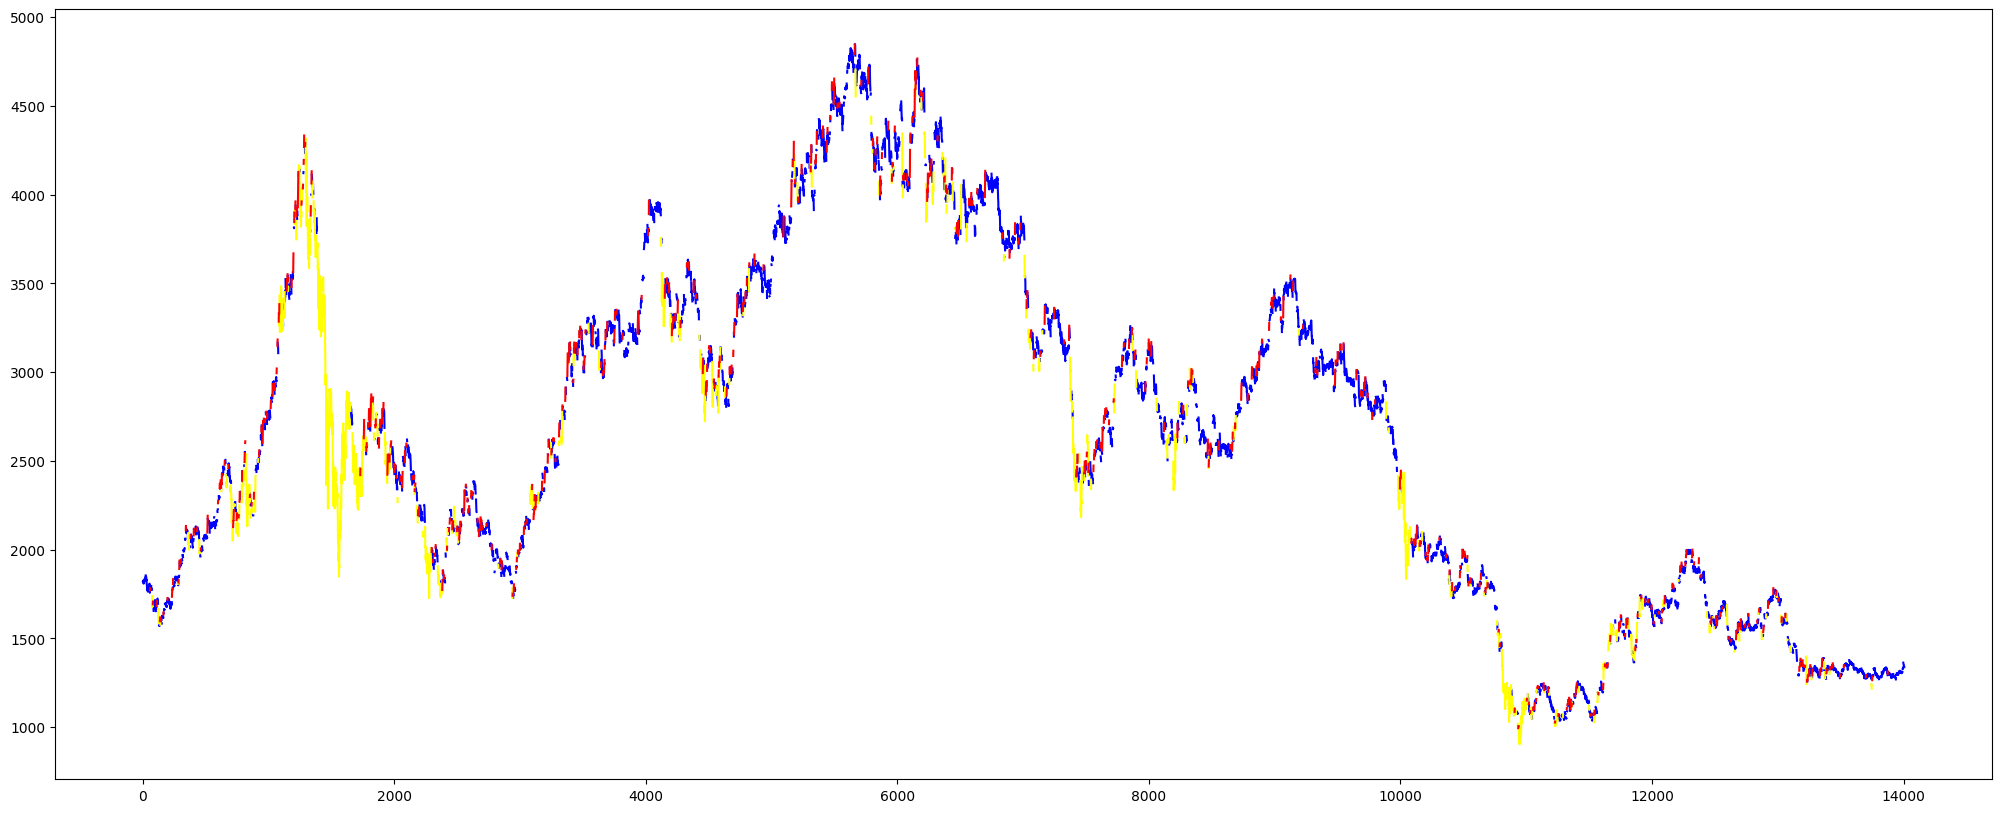

In [17]:
import matplotlib.pyplot as plt 
state1,state2,state3 = [],[],[]
i = 0
for state in states:
  if state == 0:
    state1.append(df['Close'][i])
    state2.append(float('nan'))
    state3.append(float('nan'))
  if state == 1:
    state2.append(df['Close'][i])
    state1.append(float('nan'))
    state3.append(float('nan'))
  if state == 2:
    state3.append(df['Close'][i])
    state2.append(float('nan'))
    state1.append(float('nan'))
  i += 1
plt.figure(figsize=(25,10))
plt.plot(state1,color='blue')
plt.plot(state2,color='yellow')
plt.plot(state3,color='red')